# Quantile Investigation with Logistic Regression Model

## Data Import And Cleaning

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from functools import partial

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = ['../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [26]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [27]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [28]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [29]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [30]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [31]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [32]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


In [33]:
# Fill all missing values with the mean
for df in test_dfs + train_dfs:
    for column in df.columns:
        number_null = np.sum(df[column].isnull())
        column_length = len(df[column])
        print('{} percent null: {:.1f}%'.format(
            column, (number_null / column_length) * 100))
        if number_null > 0:
            print("Filling {} with mean: {}\n".format(column, df[column].mean()))
            df[column] = df[column].fillna(df[column].mean()) 

Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 0.0%
ODOSat% percent null: 0.0%
ODO (mg/L) percent null: 0.0%
BGA-Phycocyanin RFU percent null: 0.0%
datetime percent null: 0.0%
Temp C percent null: 0.0%
Sp Cond (uS/cm) percent null: 0.0%
pH (mV) percent null: 0.0%
pH percent null: 0.0%
Turbidity (NTU) percent null: 3.2%
Filling Turbidity (NTU) with mean: 64.9625066543

## Quantiles

In [34]:
# Create Quantiles for min, mean, max
percentiles = [0.0, 0.5, 1.0]

In [35]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = hf.windowize(
        train_dfs[i], 'datetime', target_column, percentile=percentiles)
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = hf.windowize(
        test_dfs[i], 'datetime', target_column, percentile=percentiles)
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...


KeyError: 'BGA-Phycocyanin RFU'

In [ ]:
train_dfs[0].head()

## Logistic Regression Model

In [15]:

# combine the sets
train = train_dfs[0].append(train_dfs[1])
test = test_dfs[0].append(test_dfs[1])
# add the target
lrf.add_target_column([train, test], 
                      threshold=RFU_THRESHOLD)

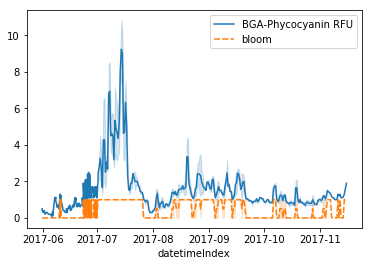

In [16]:
sns.lineplot(data=train[[target_column, 'bloom']], hue='bloom')

In [17]:
# Test Squared functionality
train.head(5)


,BGA-Phycocyanin RFU,ODO (mg/L),ODOSat%,Sp Cond (uS/cm),Temp C,Turbidity (NTU),datetime,pH,pH (mV),bloom
datetimeIndex,,,,,,,,,,
2017-05-31 14:24:00,0.4,8.86,92.00,1964.0,19.880,144.05,2017-05-31 14:24:00,8.47,-100.0,0
2017-06-01 04:24:00,0.3,8.73,91.76,1964.0,19.986,144.05,2017-06-01 04:24:00,8.47,-100.3,0
2017-06-01 18:24:00,0.3,8.67,90.30,1964.0,20.200,144.05,2017-06-01 18:24:00,8.47,-100.3,0
2017-06-02 08:24:00,0.2,8.62,89.70,1964.0,20.380,144.05,2017-06-02 08:24:00,8.48,-100.4,0
2017-06-02 22:24:00,0.3,8.62,89.90,1964.0,20.826,144.05,2017-06-02 22:24:00,8.48,-100.6,0


In [18]:
# The null model's performance
max_iter = 25000
loss = "log"
print(x_columns)
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train, test, x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train.columns)

['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)']
Accuracy 0.3695652173913043
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[221   0]
 [377   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'Sp Cond (uS/cm)',
       'Temp C', 'Turbidity (NTU)', 'datetime', 'pH', 'pH (mV)', 'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.7157190635451505
Recall: 0.5596816976127321
Precision 0.9813953488372092
Confusion Matrix:
 [[217   4]
 [166 211]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.21739130434782608
Recall: 0.08753315649867374
Precision 0.21019108280254778
Confusion Matrix:
 [[ 97 124]
 [344  33]]

Training model with: pH (mV)
Accuracy 0.6521739130434783
Recall: 1.0
Precision 0.6444444444444445
Confusion Matrix:
 [[ 13 208]
 [  0 377]]

Training model with: pH
Accuracy 0.7073578595317725
Recall: 0.843501326259947
Precision 0.7327188940092166
Confusion Matrix:
 [[105 116]
 [ 59 318]]

Training model with: Turbidity (NTU)
Accuracy 0.41638795986622074
Recall: 0.3395225464190981
Precision 0.5614035087719298
Confusion Matrix:
 [[121 100]
 [249 128]]

Training model with: ODOSat%
Accuracy 0.7274247491638796
Recall: 0.5888594164456233
Precision 0.9652173913043478
Confusion Matrix:
 [[213   8]
 [155 222]]

Training model with: ODO (mg/L)
Accuracy 0.6387959866220736
Recall

In [20]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train, test, x_columns, 'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'Temp C', 'pH', 'pH (mV)', 'ODO (mg/L)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'Temp C', 'pH', 'pH (mV)', 'ODO (mg/L)', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.7274247491638796
Test model recall: 0.5888594164456233
Test model precision: 0.9652173913043478

Updating greedy model

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.7324414715719063
Test model recall: 0.5994694960212201
Test model precision: 0.9617021276595744

Updating greedy model

Training model with: ['ODOSat%', 'Temp C', 'pH']
Test model accuracy: 0.7324414715719063
Test model recall: 0.596816976127321
Test model precision: 0.9656652360515021

Training model with: ['ODOSat%', 'Temp C', 'pH (mV)']
Test model accuracy: 0.7391304347826086
Test model recall: 0.6153846153846154
Test model precision: 0.9547325102880658

Updating greedy model

Training model with: ['ODOSat%', 

Model AUC: 0.8678


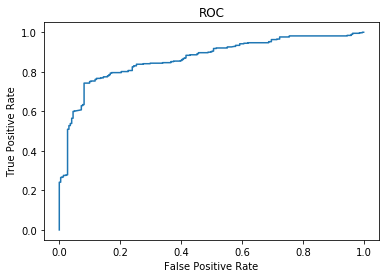

In [21]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)

## Random Forest Model

In [22]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train, test, x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.39297658862876256
Recall: 0.23076923076923078
Precision 0.54375
Confusion Matrix:
 [[148  73]
 [290  87]]


Model AUC: 0.4527


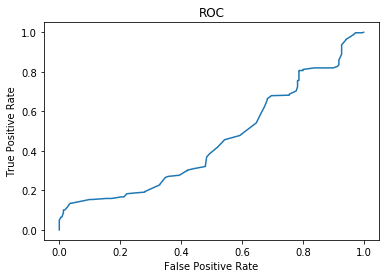

In [23]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test[['bloom']].values, predictions)